# What does this do asked Juan Carlos?

It generates Superpixels from Images (from Girder!!)

In [22]:
import girder_client
import os, cv2, json
from IPython.display import Image
import skimage.segmentation  ## from scikit-images
import numpy as np
import matplotlib.pyplot as plt
from cStringIO import StringIO
from PIL import Image as PILImage
import PIL
import superPixelHelperFunctions  as spx
import numpy
from os.path import join as oj

In [4]:
gc = girder_client.GirderClient(apiUrl="http://digitalslidearchive.emory.edu:8080/api/v1")

In [5]:
TCGACohortList = gc.get('/tcga/cohort')
cohortData = {}
for x in TCGACohortList['data']:
    cohortData[x['lowerName']] = { '_id': x['_id'], 'lowerName': x['lowerName']}

In [6]:
gbmImageSet = gc.get('/tcga/cohort/%s/images?limit=10' % cohortData['gbm']['_id'])
sampleItemToGrab = gbmImageSet['data'][4]

imgWidth = 1024
curImageMacroUrl = '/item/%s/tiles/thumbnail?width=%s' % (sampleItemToGrab['_id'],imgWidth)
curImage = gc.get(curImageMacroUrl, jsonResp=False)

In [35]:
reload(spx)

<module 'superPixelHelperFunctions' from 'superPixelHelperFunctions.py'>

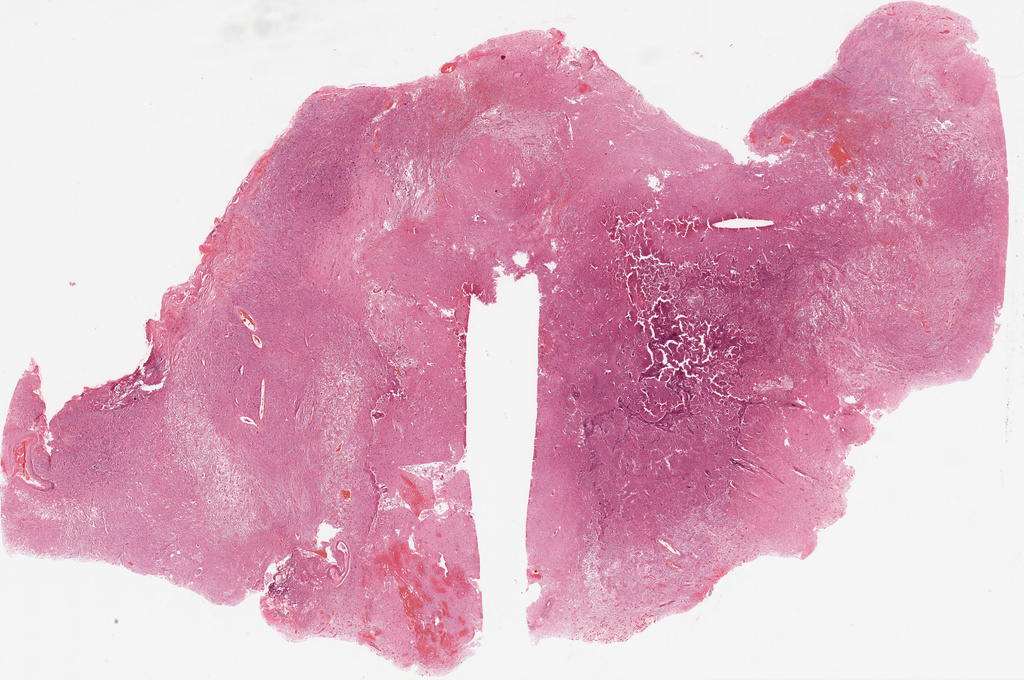

In [9]:
Image(curImage.content)

In [36]:
imagesToGrab = 10
imgWidth = 1024
macroImagePath = "./macroImages/"

if not os.path.isdir(macroImagePath):
    os.makedirs(macroImagePath)

gbmImageSet = gc.get('/tcga/cohort/%s/images?limit=%d' % ( cohortData['gbm']['_id'], imagesToGrab))

for i in gbmImageSet['data']:                     
    print i['name']
    macroName = "%s.macro.thumb.%d.png" % (i['name'].split(".")[0], imgWidth)
    numSpx = [1024,2048]
    
    if not os.path.isfile(macroName):
        curImageMacroUrl = '/item/%s/tiles/thumbnail?width=%s' % (i['_id'],imgWidth)
        curImage = gc.get(curImageMacroUrl, jsonResp=False)
        RawImageToPIL =  PILImage.open(StringIO(curImage.content)) ### This is painful.. 
        RawImageToPIL.save(oj(macroImagePath,macroName))

    for numSpx in [1024,2048]:
        spxName = "%s.macro.thumb.%d.spx.%d.png" % (i['name'].split(".")[0], imgWidth, numSpx)
        print spxName
                
        ### Need to load back the macro image
        macroImg = PILImage.open( oj(macroImagePath,macroName))

        spxImageMatrix = spx.superpixels( np.asarray(macroImg), numSegments=numSpx)
#         spxImage = PILImage.fromarray(spxImage)
        spxImage = PILImage.fromarray(spxImageMatrix)
        spxImage.save(oj(macroImagePath,spxName))


TCGA-02-0001-01C-01-BS1.0cc8ca55-d024-440c-a4f0-01cf5b3af861.svs
TCGA-02-0001-01C-01-BS1.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01C-01-BS1.macro.thumb.1024.spx.2048.png
TCGA-02-0001-01C-01-BS1.0cc8ca55-d024-440c-a4f0-01cf5b3af861.svs
TCGA-02-0001-01C-01-BS1.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01C-01-BS1.macro.thumb.1024.spx.2048.png
TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0.svs
TCGA-02-0001-01Z-00-DX2.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01Z-00-DX2.macro.thumb.1024.spx.2048.png
TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0.svs
TCGA-02-0001-01Z-00-DX2.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01Z-00-DX2.macro.thumb.1024.spx.2048.png
TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8.svs
TCGA-02-0001-01Z-00-DX3.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01Z-00-DX3.macro.thumb.1024.spx.2048.png
TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8.svs
TCGA-02-0001-01Z-00-DX3.macro.thumb.1024.spx.1024.png
TCGA-02-0001-01Z

In [7]:
spxImage = PILImage.fromarray(spxImage)

spxImage.save('sampleSuperPixelImage.png')



In [44]:
reload(spx)

<module 'superPixelHelperFunctions' from 'superPixelHelperFunctions.py'>

In [54]:
reload(spx)
sampleSPXFile  = oj(macroImagePath,spxName)


sampleSPXFile = '/home/dagutman/dev/dsa_girder_webix_base_viewer/experimental/superPixelGeneration/macroImages/TCGA-02-0001-01Z-00-DX2.macro.thumb.1024.spx.1024.png'


spxBoundaryFilesndaryFiles = spx.TileMap_to_SVG(sampleSPXFile,useRawFile=True)

[{'geometry': {'type': 'polygon', 'coordinates': [(1.0, 1.0), (1.0, 20.0), (4.0, 20.0), (5.0, 19.0), (9.0, 19.0), (10.0, 18.0), (20.0, 18.0), (21.0, 17.0), (22.0, 17.0), (23.0, 16.0), (24.0, 16.0), (27.0, 13.0), (27.0, 12.0), (28.0, 11.0), (28.0, 6.0), (29.0, 5.0), (29.0, 3.0), (30.0, 2.0), (30.0, 1.0)]}, 'properties': {'labelindex': '0'}}, {'geometry': {'type': 'polygon', 'coordinates': [(31.0, 1.0), (31.0, 2.0), (30.0, 3.0), (30.0, 5.0), (29.0, 6.0), (29.0, 11.0), (28.0, 12.0), (28.0, 13.0), (25.0, 16.0), (26.0, 17.0), (27.0, 17.0), (29.0, 19.0), (30.0, 19.0), (31.0, 20.0), (32.0, 20.0), (36.0, 24.0), (37.0, 24.0), (38.0, 25.0), (39.0, 25.0), (40.0, 26.0), (44.0, 26.0), (45.0, 25.0), (45.0, 24.0), (46.0, 23.0), (49.0, 23.0), (49.0, 21.0), (50.0, 20.0), (50.0, 18.0), (52.0, 16.0), (52.0, 15.0), (54.0, 13.0), (54.0, 12.0), (59.0, 7.0), (60.0, 7.0), (66.0, 1.0)]}, 'properties': {'labelindex': '1'}}, {'geometry': {'type': 'polygon', 'coordinates': [(67.0, 1.0), (60.0, 8.0), (59.0, 8.0), 